

---
# <center> Analysis of Financial Time Series </center>
## <center> Berkshire Hathaway Inc. (BRK-B) </center>

---    






# Libraries



In [ ]:
# Basic packages
import pandas as pd
import numpy as np
import datetime
import itertools

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from scipy.stats import kurtosis, skew
from scipy.stats.distributions import chi2
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

# Time Series
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

!pip install arch
import arch

#APIs
!pip install wikipedia
import wikipedia
from IPython.display import display, Markdown
import pandas_datareader.data as web   

# Settings
import warnings
warnings.filterwarnings("ignore") 

# General settings

This section contains the functions that will be called later in the notebook:

*   Plot: `ts_polts()`
*   Mean and Standard Deviation of a Time Series: `meanstd()`
*   Dickey-Fuller Test: `test_stationarity()`
*   Jarque-Bera Test: `normality()`
*   Likelihood-Ratio test: `lrtest()`
*   Ljung-Box Test: `lbq_test()`
*   Engle's Test: `engle_test()`




## Plots
Time series plot together with autocorrelation and partial autocorrelation plots

In [ ]:
def ts_plots(serie, title):
    # Settings
    plt.figure(figsize=(16,15))
    layout = (3, 2)
    sns.set_theme()
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2, rowspan=2)
    sns.set_style("white")
    acf_ax = plt.subplot2grid(layout, (2, 0))
    pacf_ax = plt.subplot2grid(layout, (2, 1))
    # Plot time series
    ts_ax.set_title('Time Series Analysis Plots\n{} of {}'.format(title,tickers))
    ts_ax.plot(serie, label='{}'.format(tickers))
    ts_ax.legend(loc='best')
    # Plot ACF & PACF
    plot_acf(serie, ax=acf_ax)
    plot_pacf(serie, ax=pacf_ax)


## Mean & Std of a Time Series

In [ ]:
def meanstd(serie, cv=0):
    mean = np.asarray(serie).mean()
    std = np.asarray(serie).std()
    CV = std/mean   # Coefficient of Variation
    print("Mean value of the time series: {:5f}".format(mean))
    print('Standard deviation of the time series: {:5f}'.format(std))
    if cv==1:
      print('The coefficient of variation is {:2f}'.format(CV))

## Augmented Dickey-Fuller Test
H0: *a unit root is present in a time series sample*

In [ ]:
def test_stationarity(serie):
    print('\033[1mResults of Augmented Dickey-Fuller Test:\033[0m')
    dftest = adfuller(serie.values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags ','# Observations'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    print()
    if dftest[1] > 0.05:
      print("p-value > 0.05, H0 not rejected → \033[1mNon-stationary\033[0m time series")
    else:
      print("p-value < 0.05, H0 rejected → \033[1mStationary\033[0m time series")

## Jarque-Bera Test
H0: *sample data have the skewness and kurtosis matching a normal distribution*

In [ ]:
def normality(serie, alphaJB = 0.05, plot=0):
    jarque_bera_test = stats.jarque_bera(serie)
    print('\033[1mJarque-Bera Test\033[0m (H0: sample data have the skewness and kurtosis matching a normal distribution)\n')
    if jarque_bera_test[1] < alphaJB :
      print('Hypothesis H0 rejected with p-value = {:3e} and significance level alpha = {}'.format(jarque_bera_test[1],alphaJB))
    else :
       print('Hypothesis H0 not rejected with p-value = {:3e} and significance level alpha = {}'.format(jarque_bera_test[1],alphaJB))
    print('\nKurtosis = {}\nSkewness = {}\n'.format(kurtosis(serie), skew(serie)))

    if plot == 1:
      sns.displot(serie, kde=True)

## Likelihood-Ratio test
H0: *restrictions hold*

In [ ]:
def lrtest(lower_order_model, higher_order_model):
    print("\n\033[1mLikelihood-Ratio test\033[0m (H0: restrictions hold)")
    if type(lower_order_model) == arch.univariate.base.ARCHModelResult:
      lr = 2 * (higher_order_model.loglikelihood - lower_order_model.loglikelihood)
    else:
      lr = 2 * (higher_order_model.llf - lower_order_model.llf)  
    max_pq = len(higher_order_model.params)-1 #total parameters of higher model
    min_pq = len(lower_order_model.params)-1  #total parameters of lower model
    degree_of_freedom = max_pq - min_pq
    p = stats.chisqprob(lr, degree_of_freedom) 
      
    if p < 0.05 :
      print('Hypothesis H0 rejected with p-value = {:3e} -> restrictions do not hold\n'.format(p))
    else :
       print('Hypothesis H0 not rejected with p-value = {:3e} -> restrictions hold\n'.format(p))

## Ljung-Box Test
H0: *the samples are uncorrelated*

In [ ]:
def lbq_test(res, alphaLBQ = 0.05, lags = 10,  plot = 0):
    lbq = acorr_ljungbox(res, lags=lags)
    print('\033[1mLjung-Box Test\033[0m (H0: the samples are uncorrelated)\n')
    for i in lbq[1]:
      if i < alphaLBQ:
        print('Hypothesis H0 rejected → the samples are correlated\n')
        break
    else:
      print('Hypothesis H0 not rejected → the samples are uncorrelated\n')

    if plot == 1:
      plt.rcParams["figure.figsize"] = 8, 4
      sns.set_style("white")
      acf_lbq = plot_acf(res, lags=lags, alpha=alphaLBQ)

## Engle's Test
H0: *residuals exhibit no conditional heteroscedasticity*

In [ ]:
def engle_test(res, alphaARCH = 0.05, lags = 10,  plot = 0):
    engle = sm.stats.diagnostic.het_arch(res)
    print('\033[1mEngel Test\033[0m (H0: residuals exhibit no conditional heteroscedasticity)\n')
    if engle[1] < alphaARCH :
      print('Hypothesis H0 rejected with p-value = {:3e} and significance level alpha = {}\n'.format(engle[1],alphaARCH))
    else :
       print('Hypothesis H0 not rejected with p-value = {:3e} and significance level alpha = {}\n'.format(engle[1],alphaARCH))

    if plot == 1:
      plt.rcParams["figure.figsize"] = 8, 4
      sns.set_style("white")
      acf = plot_acf(res**2, lags=lags, alpha=alphaARCH)

# Import dataset
The dataset is automatically imported from **Yahoo Finance API**. The user simply has to enter the ticker of the stock to be analyzed and a historical series with all closing prices from 1996 to today will be returned in output (in case the company has been listed after 1996, from the date of listing to today). Once the dataset has been imported, the company summary is automatically printed directly from the reference page on *Wikipedia*


In [ ]:
# Settings
tickers = input("Stock Ticker: ")
start_date = '1996-01-01'
get_px = web.DataReader(tickers, 'yahoo', start = start_date)['Adj Close']

# Import Adjusted close prices from Yahoo Finance's API
data = pd.DataFrame(get_px)

# Summary of the company from Wikipedia
display(Markdown(wikipedia.summary(tickers)))

Stock Ticker: BRK-B


Berkshire Hathaway Inc. () is an American multinational conglomerate holding company headquartered in Omaha, Nebraska, United States. The company wholly owns GEICO, Duracell, Dairy Queen, BNSF, Lubrizol, Fruit of the Loom, Helzberg Diamonds, Long & Foster, FlightSafety International, Pampered Chef, Forest River, and NetJets, and also owns 38.6% of Pilot Flying J; and significant minority holdings in public companies Kraft Heinz Company (26.7%), American Express (18.8%), The Coca-Cola Company (9.32%), Bank of America (11.9%), and Apple (6.3%).Beginning in 2016, the company acquired large holdings in the major US airline carriers, namely United Airlines, Delta Air Lines, Southwest Airlines, and American Airlines, but sold all of its airline holdings early in 2020. Berkshire Hathaway has averaged an annual growth in book value of 19.0% to its shareholders since 1965 (compared to 9.7% from the S&P 500 with dividends included for the same period), while employing large amounts of capital, and minimal debt.The company is known for its control and leadership by Warren Buffett, who serves as chairman and chief executive, and by Charlie Munger, one of the company's vice-chairmen. In the early part of his career at Berkshire, Buffett focused on long-term investments in publicly traded companies, but more recently he has more frequently bought whole companies. Berkshire now owns a diverse range of businesses including confectionery, retail, railroads, home furnishings, encyclopedias, manufacturers of vacuum cleaners, jewelry sales, manufacture and distribution of uniforms, and several regional electric and gas utilities.
According to the Forbes Global 2000 list and formula, Berkshire Hathaway is the eighth-largest public company in the world, the tenth-largest conglomerate by revenue and the largest financial services company by revenue in the world.As of August 2020, Berkshire's Class B stock is the seventh-largest component of the S&P 500 Index (which is based on free-float market capitalization) and the company is famous for having the most expensive share price in history with Class A shares costing around $400,000 each. This is because there has never been a stock split in its Class A shares and Buffett stated in a 1984 letter to shareholders that he does not intend to split the stock.

# Data pre-processing

Once imported, the dataset is *pre-processed*: 

*   Since the data is stock market data, we will not observe any value for the weekends. We convert our dates to follow the business days format (5 days a week)
*   Handling missing values with `method = 'ffill'`→ fills the missing values with the values encountered just before the missing value.

Subsequently, the columns of the *percentage returns*, the *logarithmic returns* and the *volatility* are added to the dataset. 

As a last step, the dataset is divided  into ***Train set*** and ***Test set***. The two new data sets will be used respectively for estimating the parameters of the models and for evaluating their performance. The Test set is composed of the data relating to the last year of trading (the last 252 working days) while the Train set is made up of the remaining data.



In [ ]:
# Update frequency (Business days)
data = data.asfreq("b")

# Handling missing values (values encountered just before the missing values)
data['Adj Close'] = data['Adj Close'].fillna(method='ffill')

# Log returns, % returns and volatility
data['Log Ret'] = np.log(data['Adj Close']) - np.log(data['Adj Close'].shift(1))
data['Returns'] = data['Adj Close'].pct_change(1).mul(100)
data['Volatility'] = data['Returns'].abs()

# Split in tain and test set (test on the last one year data)
train_df = data.iloc[:-252]
test_df = data.iloc[-252:]

print("Train Set Shape -", train_df.shape)
print("Test Set Shape -", test_df.shape)

Train Set Shape - (6303, 4)
Test Set Shape - (252, 4)


# Preliminary Analysis



## Prices

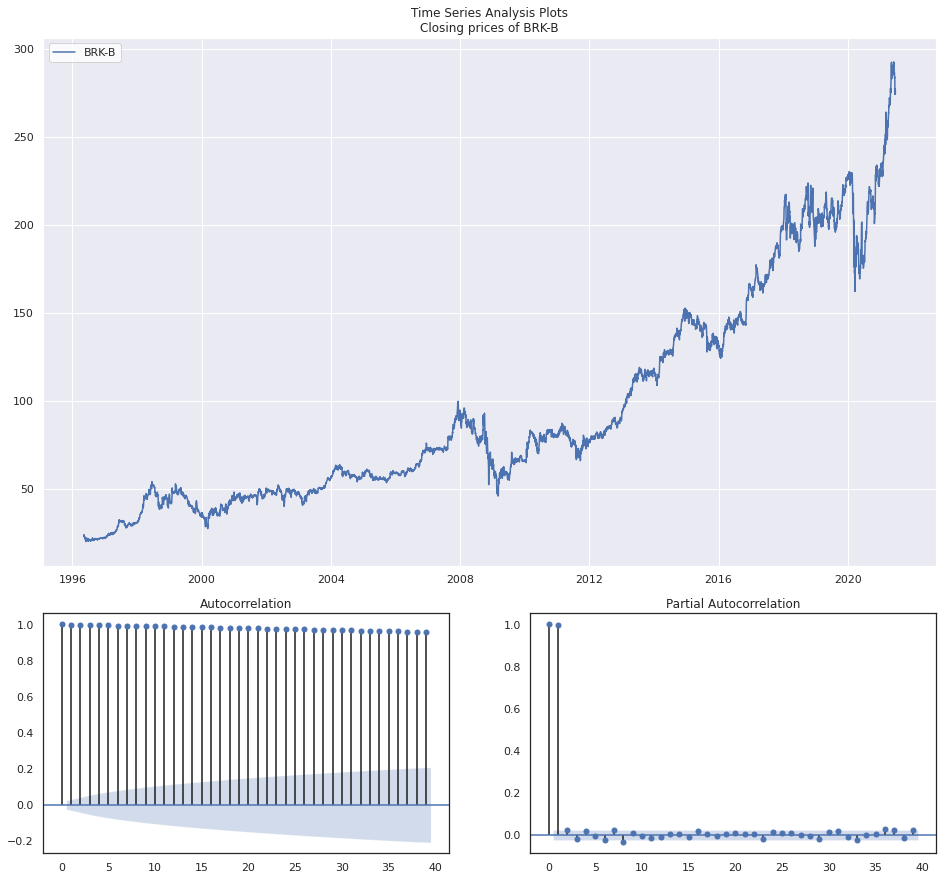

In [ ]:
ts_plots(data['Adj Close'],'Closing prices')

In [ ]:
test_stationarity(data['Adj Close'])
print()
meanstd(data['Adj Close'], cv=1)

Results of Augmented Dickey-Fuller Test:
Test Statistic             1.604940
p-value                    0.997872
# Lags                    28.000000
# Observations          6526.000000
Critical Value (1%)       -3.431352
Critical Value (5%)       -2.861983
Critical Value (10%)      -2.567006
dtype: float64

p-value > 0.05, H0 not rejected → Non-stationary time series

Mean value of the time series: 95.060639
Standard deviation of the time series: 60.855897
The coefficient of variation is 0.640180


### Data decomposition
Data decomposition is the process of breaking the time series into 3 components: **Trend**, **Seasonality**, and **Noise**.   
The plot (zoom on seasonal component) clearly shows a repeating cycle every 5 periods. This is fairly logical as our data is stock price data. This means that the data was weekly seasonality, with the week being a business week (5 days a week). However on closer inspection the values are very very negligible, as seen from the scale of the y-axis. So, using a seasonality of 5 periods in our models might not produce great results and we will not consider it.

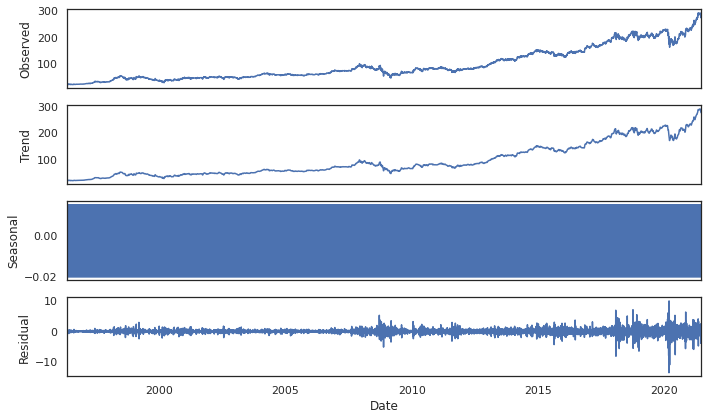

In [ ]:
# Set Plot size
plt.rcParams["figure.figsize"] = 10, 6
# Decomposing data using the "additive" model 
result = seasonal_decompose(data['Adj Close'], model='additive')
# Plot the result
result.plot()
plt.show()

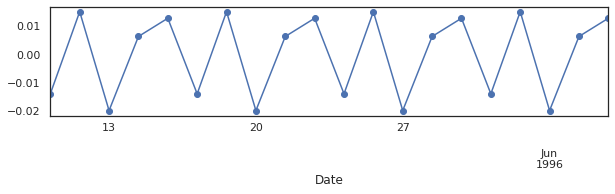

In [ ]:
# Zoom on Seasonal component
plt.rcParams["figure.figsize"] = 10, 2
result.seasonal[:20].plot(marker = "o")
plt.show()

## Returns
*Ordinary returns* and *logarithmic returns* are only equal when they are zero, but they are approximately equal when they are small. The difference between them is large only when percent changes are high. For example, an arithmetic return of +50% is equivalent to a logarithmic return of 40.55%, while an arithmetic return of −50% is equivalent to a logarithmic return of −69.31%.
Since the returns are distributed as a leptocurtis with a mean close to zero, there will be no major differences between ordinary and logarithmic returns. I choose ordinary returns for their greater interpretability.

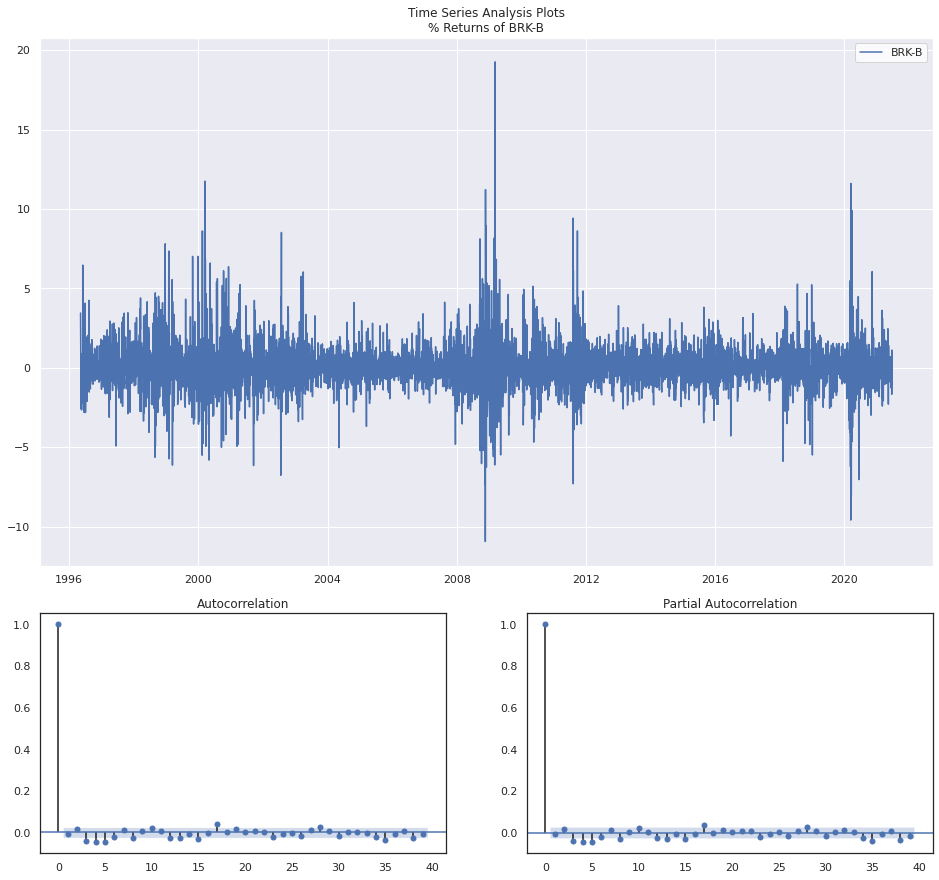

In [ ]:
ts_plots(data['Returns'][1:], '% Returns')

In [ ]:
test_stationarity(data['Returns'][1:])
print()
meanstd(data['Returns'][1:])

Results of Augmented Dickey-Fuller Test:
Test Statistic           -21.336575
p-value                    0.000000
# Lags                    16.000000
# Observations          6537.000000
Critical Value (1%)       -3.431351
Critical Value (5%)       -2.861982
Critical Value (10%)      -2.567005
dtype: float64

p-value < 0.05, H0 rejected → Stationary time series

Mean value of the time series: 0.047781
Standard deviation of the time series: 1.423915


In [ ]:
# Average Returns
daily_return = data['Adj Close'].pct_change(1).mean() 
monthly_return =  data['Adj Close'].pct_change(21).mean() 
annual_return = data['Adj Close'].pct_change(252).mean() 

print('Average Daily Return: {:%}'.format(daily_return))
print('Average Monthly Return: {:%}'.format(monthly_return))
print('Average Annual Return: {:%}'.format(annual_return))

Average Daily Return: 0.047781%
Average Monthly Return: 0.985989%
Average Annual Return: 11.663467%


In [ ]:
# Jarque-Bera Test
normality(data['Returns'][1:])

Jarque-Bera Test (H0: sample data have the skewness and kurtosis matching a normal distribution)

Hypothesis H0 rejected with p-value = 0.000000e+00 and significance level alpha = 0.05

Kurtosis = 13.014695383228322
Skewness = 0.8541714406166833



The pdf of the data is slightly skewed to the right and leptocurtic. The presence of leptocurtosis is compatible with the hypothesis of time-dependent variance; this means that we may need an ARCH / GARCH component in the model.


---



# ARIMA model

Once defined the series to give input to the `SARIMA()` function and the range of parameters to be evaluated (seasonal parameters are not considered), the following code evaluates all possible models and returns a summary table (AIC, BIC, lags outside the confidence intervals for residuals' autocorrelation and number of coefficient with p-values between 0.05 an 0.06).

The user, based on the results achieved, can choose the best model from the table by typing the index of the desired model. If the user cannot immediately understand which is the best model from the summary table, he can decide to do a Likelihood-Ratio test between two models of different order and see which is the best.

## Estimation of parameters


In [ ]:
# DataFrame where to save the selected models
model_df = pd.DataFrame(columns=["Order","AIC","BIC","LBQ","PV "])
# Define the p, d and q parameters
d = range(0,1)
p = q = range(0, 6)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

for param in pdq:
    try:
        model = SARIMAX(train_df['Returns'][1:], order=param,
                        enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit()
        lbq = results.test_serial_correlation(method='ljungbox', lags=10)[:,1]
        if all(results.pvalues < 0.06):
            model_df = model_df.append({"Order": param, 
                                        "AIC": round(results.aic,4),
                                        "BIC": round(results.bic,4),
                                        "LBQ": sum(lbq.flatten() < 0.05),
                                        "PV ": sum(results.pvalues > 0.05)} , 
                                       ignore_index=True)
    except: continue

model_df

,Order,AIC,BIC,LBQ,PV
0,"(0, 0, 0)",22431.3608,22438.1092,8,0
1,"(0, 0, 3)",22416.0819,22443.0738,7,1
2,"(0, 0, 4)",22398.2346,22431.9738,6,1
3,"(0, 0, 5)",22378.9776,22419.4636,0,0
4,"(1, 0, 2)",22408.3302,22435.3228,9,0
5,"(1, 0, 3)",22388.4404,22422.1803,1,0
6,"(1, 0, 4)",22384.2258,22424.7128,0,0
7,"(1, 0, 5)",22379.3534,22426.5871,0,0
8,"(2, 0, 3)",22387.5200,22428.0080,0,0
9,"(3, 0, 1)",22390.6523,22424.3930,1,0


In [ ]:
# (1, 0, 3)
m1 = SARIMAX(train_df['Returns'][1:], order=(1, 0, 3),
             enforce_stationarity=False, enforce_invertibility=False).fit()
# (1, 0, 4)
m2 = SARIMAX(train_df['Returns'][1:], order=(1, 0, 4),
             enforce_stationarity=False, enforce_invertibility=False).fit()
# (1, 0, 5)
m3 = SARIMAX(train_df['Returns'][1:], order=(1, 0, 5),
             enforce_stationarity=False, enforce_invertibility=False).fit()
# (0, 0, 5)
m4 = SARIMAX(train_df['Returns'][1:], order=(0, 0, 5),
             enforce_stationarity=False, enforce_invertibility=False).fit()

In [ ]:
# Likelihood-Ratio test (1, 0, 3) vs (0, 0, 5)
lrtest(m1,m4)


Likelihood-Ratio test (H0: restrictions hold)
Hypothesis H0 rejected with p-value = 7.100408e-04 -> restrictions do not hold



In [ ]:
# Select the best model
x = int(input("Select the ARIMA model number: "))
best_order = model_df.Order[x]

# Fit the best model
arima_model = SARIMAX(train_df['Returns'][1:], order=best_order,
                      enforce_stationarity=False, enforce_invertibility=False)
arima_model = arima_model.fit()
arima_model.summary()

Select the ARIMA model number: 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                Returns   No. Observations:                 6302
Model:               SARIMAX(0, 0, 5)   Log Likelihood              -11183.489
Date:                Thu, 24 Jun 2021   AIC                          22378.978
Time:                        12:59:40   BIC                          22419.464
Sample:                    05-10-1996   HQIC                         22393.003
                         - 07-06-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0143      0.006     -2.259      0.024      -0.027      -0.002
ma.L2          0.0152      0.006      2.492      0.013       0.003       0.027
ma.L3         -0.0408      0.007     -5.974      0.000      -0.054      -0.027
ma.L4         -0.0476      0.007     -7.152      0.000      -0.061      -0.035
ma.L5         -0.0533      0.008     -6.627      0.000      -0.069      -0.038
sigma2         2.0435      0.014    145.683      0.000       2.016       2.071
===================================================================================
Ljung-Box (Q):                       75.11   Jarque-Bera (JB):             42507.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Analysis residuals
The residuals are uncorrelated but they are not independent. Furthermore, the leptocurtic distribution of the residuals highlights the phenomenon of *volatility clustering*. Ultimately, from the analysis of residuals we derive the presence of ARCH components and therefore of useful information for modeling the conditional variance of the series.

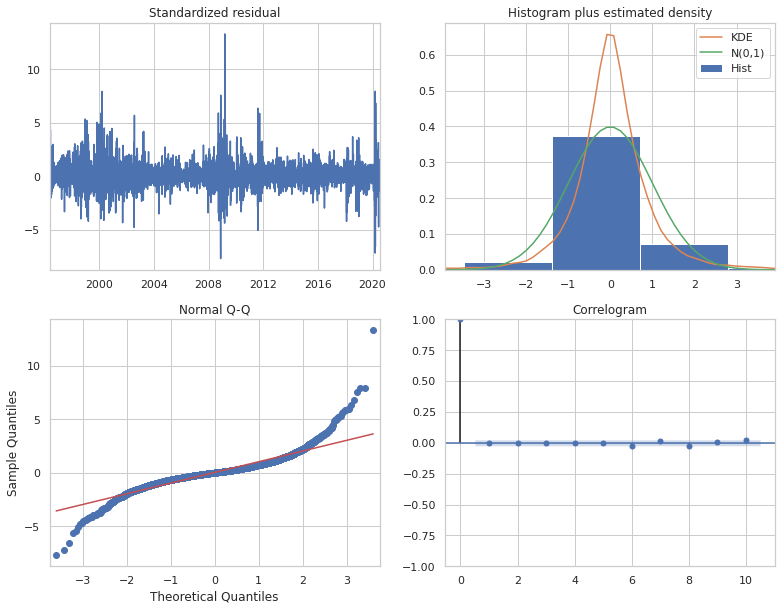

In [ ]:
# Define residuals of ARIMA model
e = arima_model.resid

# Plot diagnostic of e
sns.set_style("whitegrid")
arima_model.plot_diagnostics(figsize=(13, 10))
plt.show()

In [ ]:
# Ljung-Box test
lbq_test(e)

Ljung-Box Test (H0: the samples are uncorrelated)

Hypothesis H0 not rejected → the samples are uncorrelated



Engel Test (H0: residuals exhibit no conditional heteroscedasticity)

Hypothesis H0 rejected with p-value = 3.022208e-142 and significance level alpha = 0.05



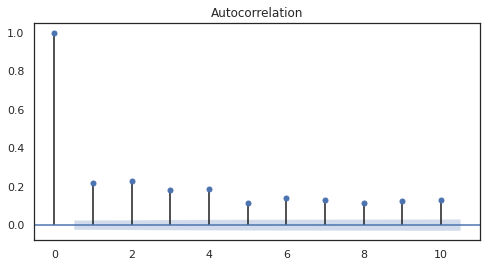

In [ ]:
# Engel Test
engle_test(e, plot=1)

## ARMA model Predictions and Confidence Intervals
In this section we use the ARMA model to forecast the Returns for the Test set. Furthermore, the same model is used to generate the confidence intervals. The **RMSE** (*Root Mean Squared Error*) metric is used to evaluate the accuracy of the predictions with respect to the actual returns in the Test set. 
On inspecting the plot (shown in the following image), the predictions are in some cases spot on, and in some cases they are wrong by huge margins. The confidence intervals do nothing to indicate how the predictions will perform in different time periods of the Test set. In some cases the confidence intervals seem too conservative, and the returns overshoot the boundaries. In other cases, the confidence intervals are not nearly conservative enough.   
To address this issue, in the next sections we will analyse the residuals of the model and try to predict when the ARMA predictions will be off by a small margin and when will they be off by a large margin.

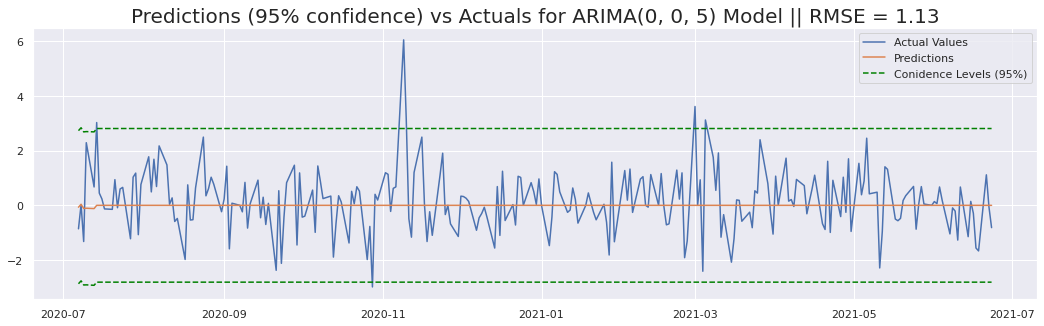

In [ ]:
# FORECASTING
# Building Forecast Object to generate Confidence Intervals
arma_forecast = arima_model.get_forecast(len(test_df.index))
arma_predictions_df = arma_forecast.conf_int(alpha = 0.05)
# Predictions
arma_predictions_df["Predictions"] = arima_model.predict(start = test_df.index[0], end = test_df.index[-1])

# RMSE for the Predictions
arma_rmse = np.sqrt(mean_squared_error(test_df["Returns"].values, arma_predictions_df["Predictions"]))

# PLOTTING FORECASTS
# Figure settings
plt.rcParams["figure.figsize"] = 18, 5
sns.set_theme()
# Plot the Actuals
plt.plot(test_df["Returns"], label = "Actual Values")
# Plot the Forecasts and the Confidence Intervals 
plt.plot(arma_predictions_df["Predictions"][test_df.index], label = "Predictions")
plt.plot(arma_predictions_df["upper Returns"][test_df.index], 
         color = "green", linestyle = "--", label = "Conidence Levels (95%)")
plt.plot(arma_predictions_df["lower Returns"][test_df.index], 
         color = "green", linestyle = "--")
# Set the Title of the Plot
plt.title(f"Predictions (95% confidence) vs Actuals for ARIMA{best_order} Model || RMSE = {round(arma_rmse, 2)}", size = 20)
# Display the plot with appropriate labels
plt.legend()
plt.show()

# GARCH model

If the residual analysis of the ARIMA model suggests the presence of arch effects, similarly to what happened for the ARIMA model estimate, the GARCH model estimate starts with the definition of the residual series to be input to the function `arch.arch_model()` and the range of parameters to be evaluated. The best GARCH model is selected by the user among those that satisfy the following conditions:

*   Significant coefficients (p-values < 0.05)
*   Null hypothesis Ljung-Box test not rejected (standardized residuals are uncorrelated)
*   Null hypothesis Engle test not rejected (standardized residuals exhibit no conditional heteroscedasticity)

As usual, if there is indecision between two models of different order, the Likelihood-Ratio test can be performed. This is not our case, in which the AIC and the BIC indicate the same model as the best.


In [ ]:
# Building Residuals DataFrame
resid_df = data.copy()
#resid_df["ret_resid"] = resid_df["Returns"].shift(1).loc[resid_df.index]
resid_df["ret_resid"] = resid_df["Returns"].loc[resid_df.index]
resid_df.at[train_df.index[1]:train_df.index[-1], "ret_resid"] = arima_model.resid

## Estimation of parameters

In [ ]:
# DataFrame where to save the selected models
garch_df = pd.DataFrame(columns=["Order","AIC","BIC"])
# Define the p and q parameters
p = q = range(0, 5)
# Generate all different combinations of p and q tuples
pq = list(itertools.product(p, q))

for param in pq:
    try:
        model = arch.arch_model(resid_df["ret_resid"][1:], mean = 'Zero',
                                p=param[0], q=param[1], vol='GARCH')
        results = model.fit(last_obs = test_df.index[0], 
                            update_freq = 5, disp='off')
        eta = results.std_resid.dropna()
        lbq = acorr_ljungbox(eta, lags=10)[1]
        if all(results.pvalues < 0.05) and all(lbq > 0.05) and het_arch(eta)[1] > 0.05:
            garch_df = garch_df.append({"Order": param, 
                                        "AIC": round(results.aic,4),
                                        "BIC": round(results.bic,4)}, 
                                       ignore_index=True)
    except: continue

garch_df

,Order,AIC,BIC
0,"(1, 1)",19843.7278,19863.9736
1,"(1, 2)",19836.7875,19863.7820


In [ ]:
x = int(input("Select the GARCH model number: "))
best_order_GARCH = garch_df.Order[x]

# Fit the best model
garch_model = arch.arch_model(resid_df["ret_resid"][1:],
                              mean = 'Zero', vol='GARCH',
                              p=best_order_GARCH[0], q=best_order_GARCH[1])
garch_model = garch_model.fit(last_obs = test_df.index[0], update_freq = 5, disp='off')
garch_model.summary()

Select the GARCH model number: 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:              ret_resid   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9914.39
Distribution:                  Normal   AIC:                           19836.8
Method:            Maximum Likelihood   BIC:                           19863.8
                                        No. Observations:                 6302
Date:                Thu, Jun 24 2021   Df Residuals:                     6302
Time:                        12:59:52   Df Model:                            0
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0510  1.444e-02      3.531  4.144e-04 [2.269e-02,7.930e-02]
alpha[1]       0.1478  2.456e-02      6.019  1.755e-09   [9.970e-02,  0.196]
beta[1]        0.5775      0.118      4.898  9.664e-07     [  0.346,  0.809]
beta[2]        0.2520      0.118      2.127  3.339e-02   [1.982e-02,  0.484]
============================================================================

Covariance estimator: robust
"""

## Analysis standardized residuals
The model has filtered out the entire stochastic component of the data leaving only noise as residual. This is confirmed by the tests carried out on the standardized residuals and squared standardized residuals (the correlation resides for both forms of the residuals within the 95% confidence bands). Furthermore, standardized residuals are characterized by mean close to 0 and variance close to 1 as expected.

Ljung-Box Test (H0: the samples are uncorrelated)

Hypothesis H0 not rejected → the samples are uncorrelated



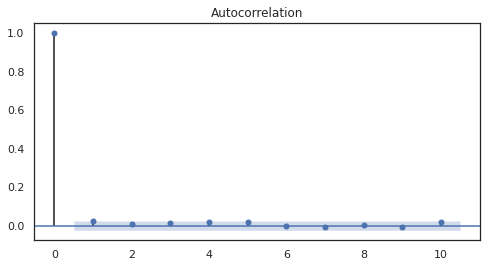

In [ ]:
eta = garch_model.std_resid.dropna()

# Analysis standardized residuals (Ljung-Box test)
lbq_test(eta, plot=1)

Engel Test (H0: residuals exhibit no conditional heteroscedasticity)

Hypothesis H0 not rejected with p-value = 3.976312e-01 and significance level alpha = 0.05



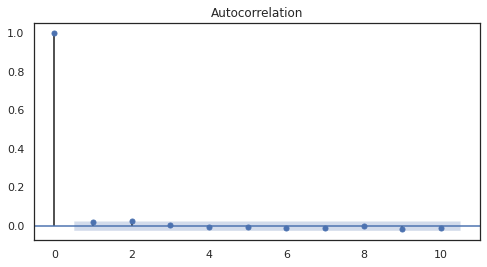

In [ ]:
# Analysis squared standardized residuals
engle_test(eta, plot=1)

In [ ]:
# Mean and Variance of standardized residuals
print('\nMean = {}\nVariance = {}\n'.format(eta.mean(), eta.var()))


Mean = 0.04191312142206622
Variance = 0.998714369127894



Jarque-Bera Test (H0: sample data have the skewness and kurtosis matching a normal distribution)

Hypothesis H0 rejected with p-value = 0.000000e+00 and significance level alpha = 0.05

Kurtosis = 3.754293928661121
Skewness = 0.23741218448636872



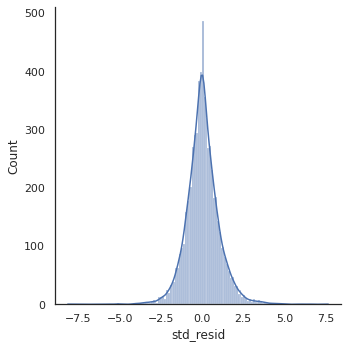

In [ ]:
# Jarque-Bera Test
normality(eta, plot=1)

## ARMA + GARCH model Predictions and Confidence Intervals

In this section we use the GARCH model fitted on residuals of ARMA model to predict the volatility of the residuals in the test set.   
The predictions from the volatility model are subtracted (and added) to the predictions from the ARMA model stored in the `arma_predictions_df` to get the lower (and upper) confidence interval(s) of the model.   
Next, the predictions (from ARMA) and the confidence intervals (from GARCH) are plotted against the actual stock Returns. On examining the plot, it is clear that when the returns are stable, and when the predictions are close to actual returns, the confidence intervals reflect this by being close. Same is true for when the Returns are unstable and the predictions are far from the Returns. In this case too the confidence intervals adjust and become far apart.   

[]

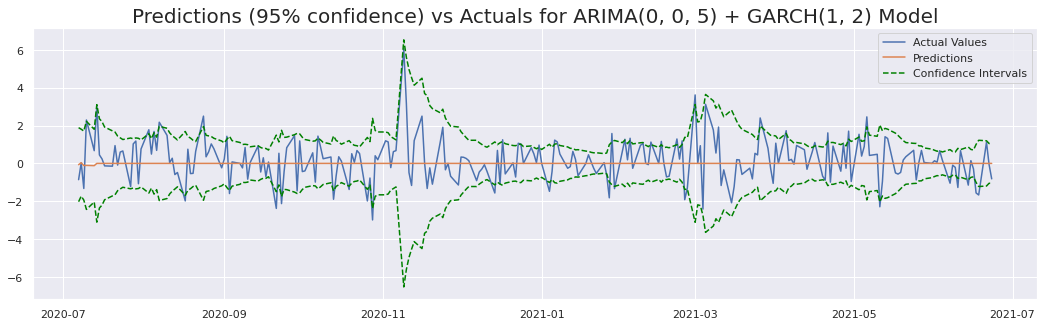

In [ ]:
# FORECASTING AND CONFIDENCE INTERVALS
# Forecasting volatility of test set
resid_forecasts = garch_model.forecast().residual_variance.loc[test_df.index].values
# New Confidence Intervals
arma_garch_predictions_df = arma_predictions_df.copy()
arma_garch_predictions_df["lower Returns"] = arma_garch_predictions_df["Predictions"] - resid_forecasts.reshape(-1,)
arma_garch_predictions_df["upper Returns"] = arma_garch_predictions_df["Predictions"] + resid_forecasts.reshape(-1,)

# PLOTTING THE FORECASTS AND CONFIDENCE INTERVALS
# Setting the figure
plt.rcParams["figure.figsize"] = 18, 5
sns.set_theme()
# Plotting the Actual Returns
plt.plot(test_df["Returns"], label = "Actual Values")
# Plot the Forecasted Returns from ARIMA 
plt.plot(arma_garch_predictions_df["Predictions"][test_df.index], label = "Predictions")
# Plot the new confidence intervals generated by the GARCH model
plt.plot(arma_garch_predictions_df["lower Returns"][test_df.index], 
         color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(arma_garch_predictions_df["upper Returns"][test_df.index], 
         color = "green", linestyle = "--")
# Set the Title of the Plot
plt.title(f"Predictions (95% confidence) vs Actuals for ARIMA{best_order} + GARCH{best_order_GARCH} Model", size = 20)
# Display the plot and the labels
plt.legend()
plt.plot()

Returning to the price series, we observe that the predictions made for the Test set are not absolutely accurate as confirmed by the metrics reported below.
It should also be emphasized that these metrics strongly depend on the time horizon of the predictions (size of the test set) and on the real values of the series taken into consideration. So these metrics are absolutely not reliable. We will see below a model that through cross-validation gives greater robustness to the metrics for the evaluation of predictive performance.



In [ ]:
# From returns to prices
arma_garch_predictions_df['Price Predictions'] = test_df['Adj Close'][0] * (1+arma_garch_predictions_df['Predictions']/100).cumprod() 
# True and Predicted values
y_true = test_df['Adj Close'].values
y_pred = arma_garch_predictions_df['Price Predictions'].values
# RMSE Metric Calculation
arma_rmse = np.sqrt(mean_squared_error(y_true , y_pred))
# Compute MAPE
abs_err=np.abs((y_true - y_pred) / y_true)
mape = np.mean(abs_err)*100

print(f"The predictions made for the Test set (last {len(test_df.index)} days) generate these statistics:")
print(f"-  RMSE: {round(arma_rmse,3)}")
print(f"-  MAPE: {round(mape,3)}%")

The predictions made for the Test set (last 252 days) generate these statistics:
-  RMSE: 63.236
-  MAPE: 22.561%




---


# Prophet
In this section we want to implement an alternative model to those studied during the "Models for Financial Applications" course.   

Prophet is a  open source software released by Facebook’s Core Data Science team for forecasting time series data based on an *additive model* where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. The Prophet model fitting procedure is usually very fast (even for thousands of observations) and it does not require any data pre-processing. It deals also with missing data and outliers.

## The Model
$$y(t) = g(t) + s(t) + h(t) +  e_t$$  

Here $g(t)$ is the trend function which models non-periodic changes in the value of the time series, $s(t)$ represents periodic changes (e.g., weekly and yearly seasonality), and $h(t)$ represents the effects of holidays which occur on potentially irregular schedules over one or more days. The error term $e_t$ represents any idiosyncratic changes which are not accommodated by the model; it is assumed normally distributed.   

## Implementation   
Once the dataset has been imported in the standard form accepted by the Prophet model, we are going to implement the model by giving the following parameters as input:
*   `interval_width = 0.95`: The width of the uncertainty intervals (by default 80%) can be set using the parameter `interval_width`. These intervals assume that the future will see the same frequency and magnitude of rate changes as the past. This assumption is probably not true, so we do not expect the uncertainty intervals to have exact coverage. They are, however, a useful indication of the level of uncertainty, and especially an indicator of overfitting.
*   `changepoint_prior_scale = 0.01`: Prophet detects changepoints by first specifying a large number of potential changepoints at which the rate is allowed to change, then using as few of them as possible. The parameter that determines how many of them to use is `changepoint_prior_scale`, which has been set to 0.01 after hyperparameter tuning. Increasing `changepoint_prior_scale` allows higher flexibility in the rate.


In [ ]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

df = pd.DataFrame()
df['y'] = data['Adj Close'].values.flatten()
df['ds'] = data['Adj Close'].index

m = Prophet(interval_width=0.95, 
            changepoint_prior_scale= 0.01, 
            daily_seasonality=False)
m = m.fit(df)

## Forecasts

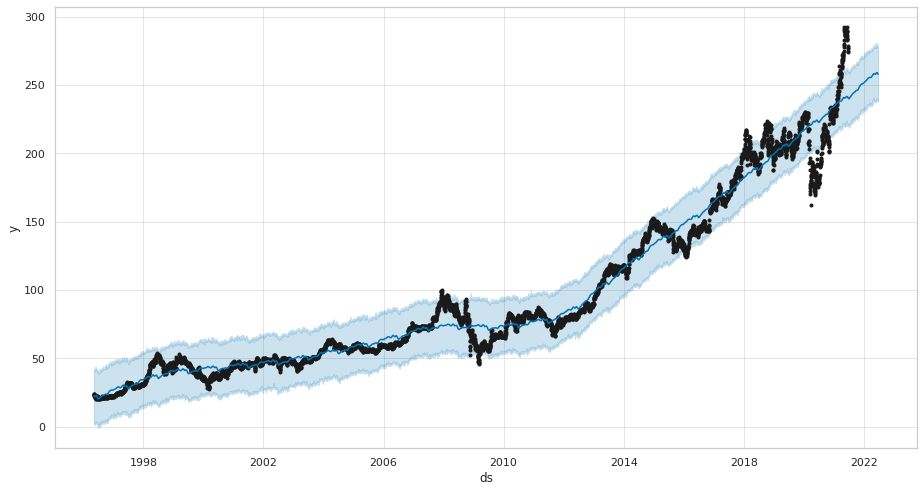

In [ ]:
future = m.make_future_dataframe(periods=365)
future = future[future['ds'].dt.dayofweek < 5]
fcst = m.predict(future)
sns.set_theme(style = 'whitegrid')
fig1 = m.plot(fcst, figsize=(13,7))

## Diagnostics
Prophet includes functionality for time series **cross validation** to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.    
The output of `cross_validation` is a dataframe with the true values y and the out-of-sample forecast values yhat, at each simulated forecast date and for each cutoff date. In particular, a forecast is made for every observed point between cutoff and cutoff + horizon. This dataframe can then be used to compute error measures of `yhat` vs. `y`.   
The `performance_metrics` utility can be used to compute some useful statistics of the prediction performance (`yhat`, `yhat_lower`, and `yhat_upper` compared to `y`), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), median absolute percent error (MDAPE) and coverage of the `yhat_lower` and `yhat_upper` estimates. 

In [ ]:
df_cv = cross_validation(m, initial='1825 days', horizon='365 days', period='365 days')
df_p = performance_metrics(df_cv)
df_p

INFO:fbprophet:Making 20 forecasts with cutoffs between 2001-06-28 00:00:00 and 2020-06-23 00:00:00


,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,139.594651,11.815018,8.110305,0.084374,0.054062,0.722649
1,38 days,138.446186,11.766316,8.147265,0.084886,0.056683,0.721141
2,39 days,134.909050,11.615035,8.115382,0.084853,0.056891,0.724760
3,40 days,133.346118,11.547559,8.102640,0.084517,0.056715,0.730646
4,41 days,135.194847,11.627332,8.176983,0.084652,0.057072,0.729367
...,...,...,...,...,...,...,...
324,361 days,496.138768,22.274173,16.476295,0.162972,0.153011,0.399232
325,362 days,488.820011,22.109274,16.340733,0.163057,0.153619,0.406526
326,363 days,489.877841,22.133184,16.378678,0.163509,0.152500,0.406910
327,364 days,495.637143,22.262910,16.485664,0.164337,0.152249,0.406910


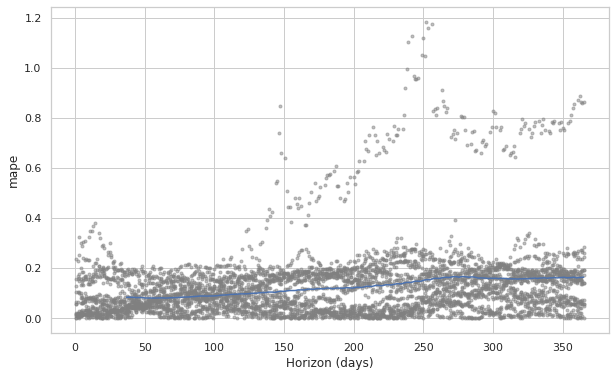

In [ ]:
fig2 = plot_cross_validation_metric(df_cv, metric='mape',figsize=(10,6))

## Insights
The graphs show an increasing trend and an annual seasonality in which the share price is higher during the first months of the year, falls until July and then continues to rise until the end of the year. The weekly seasonality, on the other hand, does not present significant patterns.

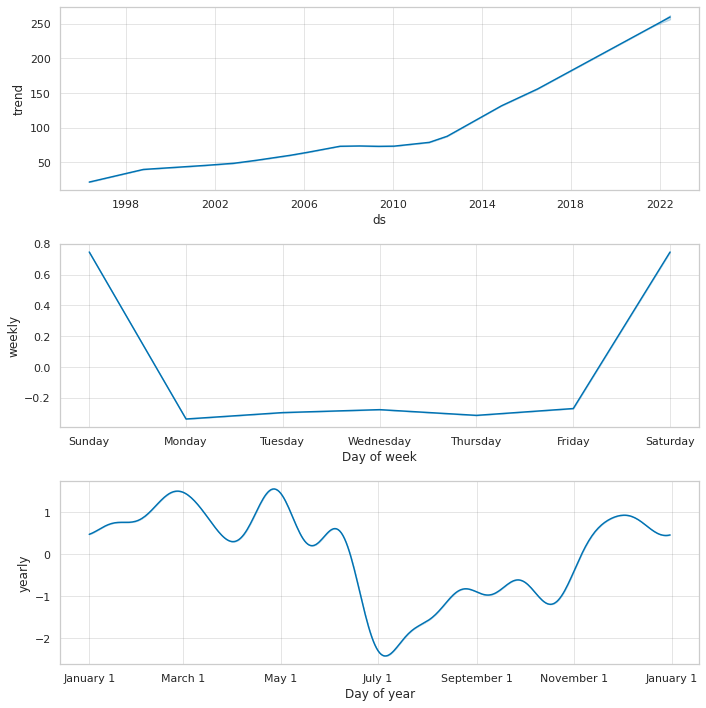

In [ ]:
fig3 = m.plot_components(fcst, figsize=(10,10))



---


# Conclusions

Using the combination of *ARMA and GARCH* models we are able to build much more meaningful forecasts compared to predictions with the ARMA model. Looking at the forecasts and confidence intervals we can understand the ballpark figure for future returns and also the stability in the market.  With the *Prophet* model, on the other hand, we achieved slightly better results over a predictive horizon of one year. Unlike the ARIMA + GARCH model, these results are more reliable because they are cross-validated. Furthermore, the Prophet model provides an immediate look at what the future trend of the reference stock could be, it is much easier to implement, has a fast computation and allows with a few lines of code to have an extremely complete diagnostics. However, the improvements reached do not lead to accurate predictions; this is because financial series do not show seasonality, and we know Prophet works better with seasonal data. In addition, making very accurate predictions on financial series is not possible and would lead to the violation of the *Efficient Market Hypothesis* (EMH). 

In conclusion, we can say that these models are a good tool to support investors in the analysis of stocks but their predictive capacity is highly dependent on external factors. In this regard, a possible improvement could be to include *macroeconomic variables* in the analysis (Inflation, Growth, Employment ...) and the search for some keywords on the internet via *Google Trends* to track down investor sentiment. The addition of these variables, along with the implementation of alternative models such as neural networks (e.g., *LSTM*) could be a step forward in the analysis of financial series.



# References

1.   [Prophet](https://facebook.github.io/prophet/)
2.   [Introduction to ARCH Models](https://arch.readthedocs.io)
3.   [statsmodels](https://www.statsmodels.org)
4.   [Statistical Modeling of Time Series](https://pub.towardsai.net/statistical-modeling-of-time-series-data-part-1-data-preparation-and-preprocessing-b52f26f6213c)
5.   [Time series Basics : Exploring traditional TS](https://www.kaggle.com/jagangupta/time-series-basics-exploring-traditional-ts)
6.  [Inference in Time Series: Prophet vs. ARIMA](https://stats.stackexchange.com/questions/472266/inference-in-time-series-prophet-vs-arima)


---





